# **Machine Learning Project - Predicting Customer Purchases to Increase Sales Revenue of a Low-Performing Product**

# **I. Objective and Scope + ML Canvas Plan**

- Week 8 | Individual Project Kickoff Project Planning
- Goal: Complete the ML Canvas (project planning)

As a data scientist working in a retail industry. These are the following things I need to consider in building an ML model:

- Marketing team consults on how to increase sales revenue of a
low-performing product.
- Create an ML model that predicts a customer that will buy the target product. Ensure that the model has the highest accuracy, precision, and recall.
- Dataset: week8_student_project.csv.gz

In [ ]:
# Installing packages
!pip install pyspark
!pip install findspark
!pip install dill

In [ ]:
# Set up pyspark
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master('local[*]') \
        .appName('Basics') \
        .getOrCreate()

print(spark.version)

3.5.5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Assigning my home directory
home_dir = '/content/drive/MyDrive/ TERM 7/MACHINE/churn_prediction'

In [ ]:
# Defining the functions
# Importing additional packages
import datetime
import csv
import yaml
import io
import dill as pickle
import os

def get_datetime():
    """Returns datetime for filename use.

    :return: datetime
    :rtype: string
    """
    stamp = datetime.datetime.now()
    datetime_name = f"{stamp.year:04}{stamp.month:02}{stamp.day:02}_{stamp.hour:02}{stamp.minute:02}"
    print(datetime_name)
    return datetime_name

print('Functions ready!')

Functions ready!


In [ ]:
# Reading the data using pyspark
df_2018_demo = spark.read.csv(f"{home_dir}/data/week8_student_project.csv.gz", inferSchema=True, header=True)
print(f"{df_2018_demo.show(5)}")
df_2018_demo.createOrReplaceTempView("df_2018_demo_view")

+----------------+-----------+------+--------------------+-----------------+----------------+------+-------+--------+--------+------+-----+---------+------------+---------+--------------------+----------------+-------------+-----------+------+-------------+
|transaction_date|member_type|branch|           member_id|transaction_month|transaction_year|gender|product|quantity|category|amount|  age|card_type|weather_date|branch_id|        weather_list|temperature_list|realfell_list|branch_name|region|category_name|
+----------------+-----------+------+--------------------+-----------------+----------------+------+-------+--------+--------+------+-----+---------+------------+---------+--------------------+----------------+-------------+-----------+------+-------------+
|      2018-04-01|     member|     E|ff96777d-cfda-11e...|              APR|            2018|FEMALE|   3267|      16|     127|  5100|30-35|  REGULAR|  2018-04-01|        E|       Partly cloudy|              24|           28|  

In [ ]:
# Checking first 5 rows of data
spark.sql('''
SELECT
  *
FROM
  df_2018_demo_view
LIMIT
  5
''').show()

+----------------+-----------+------+--------------------+-----------------+----------------+------+-------+--------+--------+------+-----+---------+------------+---------+--------------------+----------------+-------------+-----------+------+-------------+
|transaction_date|member_type|branch|           member_id|transaction_month|transaction_year|gender|product|quantity|category|amount|  age|card_type|weather_date|branch_id|        weather_list|temperature_list|realfell_list|branch_name|region|category_name|
+----------------+-----------+------+--------------------+-----------------+----------------+------+-------+--------+--------+------+-----+---------+------------+---------+--------------------+----------------+-------------+-----------+------+-------------+
|      2018-04-01|     member|     E|ff96777d-cfda-11e...|              APR|            2018|FEMALE|   3267|      16|     127|  5100|30-35|  REGULAR|  2018-04-01|        E|       Partly cloudy|              24|           28|  

In [ ]:
# Checking the partition dates
spark.sql('''
SELECT
  MIN(transaction_date)
  ,MAX(transaction_date)
FROM
  df_2018_demo_view
''').show()

+---------------------+---------------------+
|min(transaction_date)|max(transaction_date)|
+---------------------+---------------------+
|           2018-01-01|           2019-12-31|
+---------------------+---------------------+



In [ ]:
# Checking the count of transactions for 2018 data
spark.sql('''
SELECT
  COUNT(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-12-31' THEN 1 ELSE NULL END) AS 2018_total_txns
  ,COUNT(CASE WHEN transaction_date BETWEEN '2019-01-01' AND '2019-12-31' THEN 1 ELSE NULL END) AS 2019_total_txns
  ,COUNT(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2019-12-31' THEN 1 ELSE NULL END) AS total_txns
FROM
  df_2018_demo_view
''').show()

+---------------+---------------+----------+
|2018_total_txns|2019_total_txns|total_txns|
+---------------+---------------+----------+
|        2179008|        2176320|   4355328|
+---------------+---------------+----------+



In [ ]:
# Getting the transaction count per month
spark.sql('''
SELECT
    transaction_year,
    transaction_month,
    COUNT(*) AS transaction_count
FROM df_2018_demo_view
GROUP BY transaction_year, transaction_month
ORDER BY transaction_year,
         CASE
             WHEN transaction_month = 'JAN' THEN 1
             WHEN transaction_month = 'FEB' THEN 2
             WHEN transaction_month = 'MAR' THEN 3
             WHEN transaction_month = 'APR' THEN 4
             WHEN transaction_month = 'MAY' THEN 5
             WHEN transaction_month = 'JUN' THEN 6
             WHEN transaction_month = 'JUL' THEN 7
             WHEN transaction_month = 'AUG' THEN 8
             WHEN transaction_month = 'SEP' THEN 9
             WHEN transaction_month = 'OCT' THEN 10
             WHEN transaction_month = 'NOV' THEN 11
             WHEN transaction_month = 'DEC' THEN 12
         END
''').show(50)

+----------------+-----------------+-----------------+
|transaction_year|transaction_month|transaction_count|
+----------------+-----------------+-----------------+
|            2018|              JAN|           190117|
|            2018|              FEB|           187789|
|            2018|              MAR|           228579|
|            2018|              APR|           204935|
|            2018|              MAY|           308383|
|            2018|              JUN|           292253|
|            2018|              JUL|            94626|
|            2018|              AUG|            42902|
|            2018|              OCT|           203725|
|            2018|              NOV|           133960|
|            2018|              DEC|           291739|
|            2019|              JAN|           188948|
|            2019|              FEB|           188600|
|            2019|              MAR|           227770|
|            2019|              APR|           204166|
|         

In [ ]:
# Checking the category of products
spark.sql('''
WITH
distinct_productcategory AS (
SELECT
  DISTINCT CAST(product AS STRING) AS product_id
  ,category_name
FROM
  df_2018_demo_view
)

SELECT
  category_name
  ,COUNT(category_name) AS product_count
  ,COUNT(DISTINCT product_id) AS cntd_product
FROM
  distinct_productcategory
GROUP BY
  category_name
ORDER BY
  category_name
''').show()

+-------------+-------------+------------+
|category_name|product_count|cntd_product|
+-------------+-------------+------------+
|  ACCESSORIES|         1020|        1020|
|   APPLIANCES|          989|         989|
|     CLEANERS|         1035|        1035|
|      CLOTHES|          990|         990|
|         FOOD|          976|         976|
|  FROZEN FOOD|         1014|        1014|
|      GADGETS|          953|         953|
|     HARDWARE|         1034|        1034|
|          PET|         1022|        1022|
|        SHOES|          967|         967|
+-------------+-------------+------------+



In [ ]:
low_performing_gadgets = spark.sql('''
    SELECT product, COUNT(*) AS transaction_count, SUM(amount) AS total_sales
    FROM df_2018_demo_view
    WHERE category_name = 'GADGETS'
    GROUP BY product
    ORDER BY transaction_count ASC
    LIMIT 10
''')
low_performing_gadgets.show()

+-------+-----------------+-----------+
|product|transaction_count|total_sales|
+-------+-----------------+-----------+
|   9980|              103|     669500|
|   6850|              103|     288400|
|   7236|              105|     745500|
|   7335|              105|     273000|
|   7451|              106|     763200|
|   7213|              107|     866700|
|   6840|              109|     991900|
|   7405|              112|     873600|
|   6791|              113|     248600|
|   6836|              113|     858800|
+-------+-----------------+-----------+



In [ ]:
# Customer Demographics
customer_demographics = spark.sql('''
    SELECT age, gender, COUNT(*) AS purchase_count
    FROM df_2018_demo_view
    WHERE category_name = 'GADGETS' AND product = 6850
    GROUP BY age, gender
    ORDER BY purchase_count DESC
''')
customer_demographics.show()

+--------+------+--------------+
|     age|gender|purchase_count|
+--------+------+--------------+
|   50-55|FEMALE|            17|
|   55-60|FEMALE|            12|
|   55-60|  MALE|            11|
|   50-55|  MALE|             9|
|   45-50|FEMALE|             8|
|   35-40|FEMALE|             7|
|   18-25|FEMALE|             6|
|60 Above|FEMALE|             6|
|   40-45|FEMALE|             6|
|   30-35|FEMALE|             4|
|   25-30|  MALE|             3|
|   45-50|  MALE|             3|
|   25-30|FEMALE|             3|
|   35-40|  MALE|             3|
|   30-35|  MALE|             2|
|   40-45|  MALE|             2|
|60 Above|  MALE|             1|
+--------+------+--------------+



In [ ]:
# Feature Variability
feature_variability = spark.sql('''
    SELECT DISTINCT branch_name, weather_list, card_type
    FROM df_2018_demo_view
    WHERE product = 6850
''')
feature_variability.show()

+-----------+--------------------+---------+
|branch_name|        weather_list|card_type|
+-----------+--------------------+---------+
|    G_Store|Partly sunny w sh...|  REGULAR|
|    F_Store|        Mostly clear|  REGULAR|
|    F_Store|       Partly cloudy|  PREMIUM|
|    D_Store|Partly sunny w sh...|  PREMIUM|
|    E_Store|Mostly cloudy w s...|  REGULAR|
|    G_Store|              Cloudy|  REGULAR|
|    H_Store|                Rain|  REGULAR|
|    G_Store|             Showers|  REGULAR|
|    C_Store|               Sunny|  REGULAR|
|    D_Store|        Mostly clear|  REGULAR|
|    G_Store|       Thunderstorms|  REGULAR|
|    H_Store|               Sunny|  REGULAR|
|    A_Store|       Partly cloudy|  REGULAR|
|    A_Store|        Mostly sunny|  PREMIUM|
|    C_Store|        Partly sunny|  REGULAR|
|    J_Store|       Thunderstorms|  REGULAR|
|    G_Store|               Clear|  REGULAR|
|    I_Store|              Cloudy|  REGULAR|
|    I_Store|               Sunny|  PREMIUM|
|    F_Sto

In [ ]:
# Prepare Data for ML Model
df_6850 = spark.sql('''
    SELECT member_type, branch, age, gender, quantity, amount, card_type, weather_list, temperature_list, realfell_list
    FROM df_2018_demo_view
    WHERE product = 6850
''')
df_6850.show(5)

+-----------+------+-----+------+--------+------+---------+--------------------+----------------+-------------+
|member_type|branch|  age|gender|quantity|amount|card_type|        weather_list|temperature_list|realfell_list|
+-----------+------+-----+------+--------+------+---------+--------------------+----------------+-------------+
|     member|     I|50-55|  MALE|      12|  2800|  REGULAR|              Cloudy|              28|           32|
|     member|     D|50-55|  MALE|      18|  2800|  REGULAR|        Partly sunny|              29|           33|
|     member|     A|35-40|  MALE|       9|  2800|  REGULAR|Mostly cloudy w t...|              32|           36|
|     member|     B|50-55|FEMALE|      16|  2800|  REGULAR|Mostly cloudy w s...|              33|           37|
|     member|     E|50-55|FEMALE|      16|  2800|  REGULAR|              Cloudy|              32|           36|
+-----------+------+-----+------+--------+------+---------+--------------------+----------------+-------

In [ ]:
# Define the Target Variable
from pyspark.sql.functions import lit

# Buyers of Product 6850
df_buyers = df_6850.withColumn("target", lit(1))

# Non-Buyers: Customers who bought gadgets but not 6850
df_non_buyers = spark.sql('''
    SELECT member_type, branch, age, gender, quantity, amount, card_type, weather_list, temperature_list, realfell_list
    FROM df_2018_demo_view
    WHERE category_name = 'GADGETS' AND product != 6850
    LIMIT 500  -- Balance data by limiting non-buyers
''').withColumn("target", lit(0))

# Combine both datasets
df_final = df_buyers.union(df_non_buyers)
df_final.show(10)

+-----------+------+-----+------+--------+------+---------+--------------------+----------------+-------------+------+
|member_type|branch|  age|gender|quantity|amount|card_type|        weather_list|temperature_list|realfell_list|target|
+-----------+------+-----+------+--------+------+---------+--------------------+----------------+-------------+------+
|     member|     I|50-55|  MALE|      12|  2800|  REGULAR|              Cloudy|              28|           32|     1|
|     member|     D|50-55|  MALE|      18|  2800|  REGULAR|        Partly sunny|              29|           33|     1|
|     member|     A|35-40|  MALE|       9|  2800|  REGULAR|Mostly cloudy w t...|              32|           36|     1|
|     member|     B|50-55|FEMALE|      16|  2800|  REGULAR|Mostly cloudy w s...|              33|           37|     1|
|     member|     E|50-55|FEMALE|      16|  2800|  REGULAR|              Cloudy|              32|           36|     1|
|     member|     D|55-60|  MALE|      19|  2800

# **II. Data - Descriptive Statistics**

In [ ]:
# Convert to Pandas
df_pandas = df_final.toPandas()

# Summary Statistics
df_pandas.describe()

,quantity,amount,temperature_list,realfell_list,target
count,603.000000,603.000000,603.000000,603.000000,603.000000
mean,10.187396,4586.733002,26.295191,30.295191,0.170813
std,5.430905,2687.646732,5.247916,5.247916,0.376658
min,1.000000,100.000000,18.000000,22.000000,0.000000
25%,5.500000,2800.000000,22.000000,26.000000,0.000000
50%,10.000000,3700.000000,27.000000,31.000000,0.000000
75%,15.000000,6800.000000,31.000000,35.000000,0.000000
max,19.000000,9900.000000,35.000000,39.000000,1.000000


In [ ]:
# Buyers vs. Non-Buyers
# Split into buyers and non-buyers
buyers = df_pandas[df_pandas["target"] == 1]
non_buyers = df_pandas[df_pandas["target"] == 0]

# Compare statistics
buyers.describe(), non_buyers.describe()

(         quantity  amount  temperature_list  realfell_list  target
 count  103.000000   103.0        103.000000     103.000000   103.0
 mean     9.640777  2800.0         26.223301      30.223301     1.0
 std      5.586844     0.0          5.426753       5.426753     0.0
 min      1.000000  2800.0         18.000000      22.000000     1.0
 25%      5.000000  2800.0         22.000000      26.000000     1.0
 50%     10.000000  2800.0         27.000000      31.000000     1.0
 75%     15.000000  2800.0         31.000000      35.000000     1.0
 max     19.000000  2800.0         35.000000      39.000000     1.0,
         quantity       amount  temperature_list  realfell_list  target
 count  500.00000   500.000000        500.000000     500.000000   500.0
 mean    10.30000  4954.800000         26.310000      30.310000     0.0
 std      5.39706  2814.206189          5.215775       5.215775     0.0
 min      1.00000   100.000000         18.000000      22.000000     0.0
 25%      6.00000  2800.000

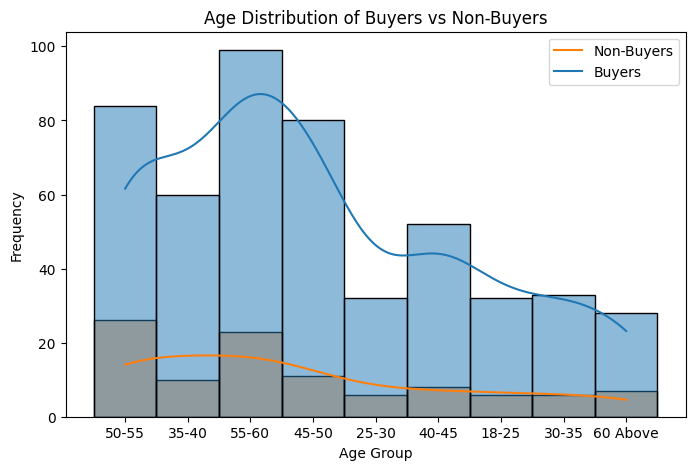

In [ ]:
# Age Distribution of Buyers vs Non-Buyers
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(data=df_pandas, x="age", hue="target", kde=True, bins=15)
plt.title("Age Distribution of Buyers vs Non-Buyers")
plt.xlabel("Age Group")
plt.ylabel("Frequency")
plt.legend(["Non-Buyers", "Buyers"])
plt.show()

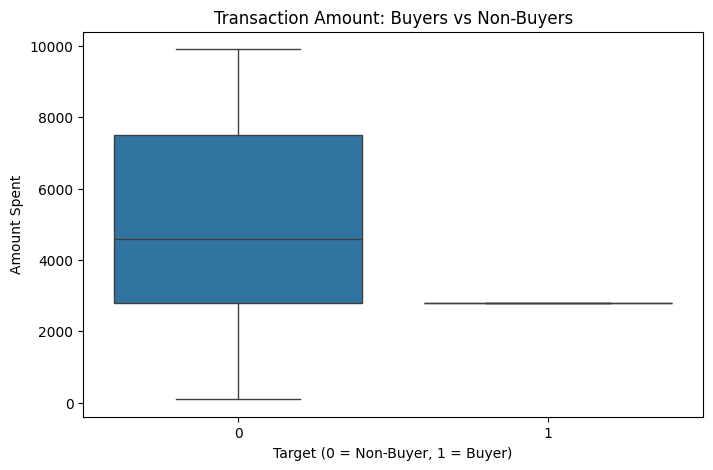

In [ ]:
# Transaction Amount Comparison
plt.figure(figsize=(8,5))
sns.boxplot(x="target", y="amount", data=df_pandas)
plt.title("Transaction Amount: Buyers vs Non-Buyers")
plt.xlabel("Target (0 = Non-Buyer, 1 = Buyer)")
plt.ylabel("Amount Spent")
plt.show()

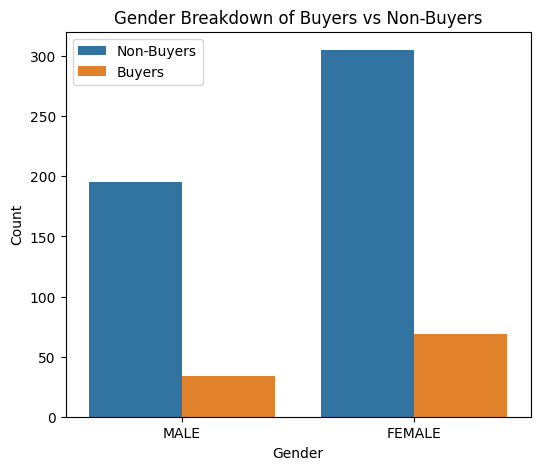

In [ ]:
# Gender Comparison
plt.figure(figsize=(6,5))
sns.countplot(x="gender", hue="target", data=df_pandas)
plt.title("Gender Breakdown of Buyers vs Non-Buyers")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(["Non-Buyers", "Buyers"])
plt.show()

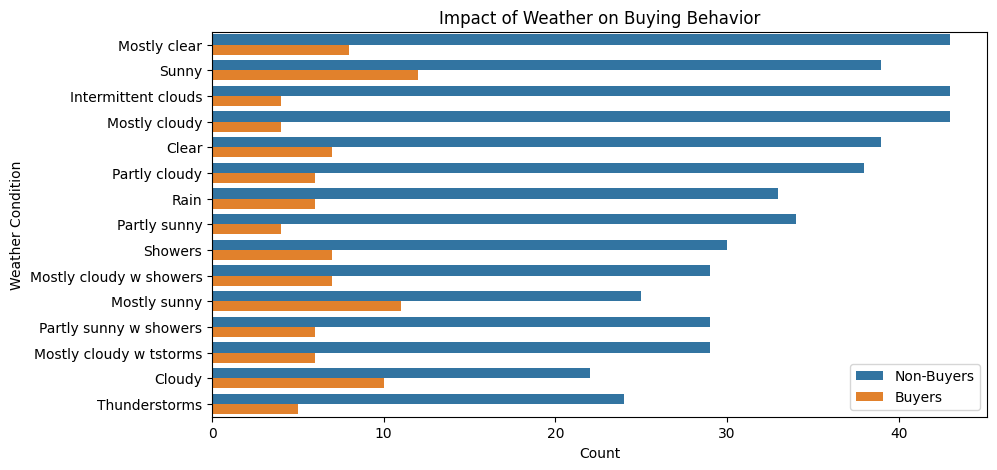

In [ ]:
# Impact of Weather on Buying Behavior
plt.figure(figsize=(10,5))
sns.countplot(y="weather_list", hue="target", data=df_pandas, order=df_pandas["weather_list"].value_counts().index)
plt.title("Impact of Weather on Buying Behavior")
plt.xlabel("Count")
plt.ylabel("Weather Condition")
plt.legend(["Non-Buyers", "Buyers"])
plt.show()

In [ ]:
# Convert Categorical Features
from pyspark.ml.feature import StringIndexer

indexers = [
    StringIndexer(inputCol="member_type", outputCol="member_type_idx"),
    StringIndexer(inputCol="branch", outputCol="branch_idx"),
    StringIndexer(inputCol="gender", outputCol="gender_idx"),
    StringIndexer(inputCol="card_type", outputCol="card_type_idx"),
    StringIndexer(inputCol="weather_list", outputCol="weather_idx")
]

In [ ]:
# Convert Age to Numeric
from pyspark.sql.functions import col, when

df_final = df_final.withColumn(
    "age",
    when(col("age") == "18-25", 1)
    .when(col("age") == "25-30", 2)
    .when(col("age") == "30-35", 3)
    .when(col("age") == "35-40", 4)
    .when(col("age") == "40-45", 5)
    .when(col("age") == "45-50", 6)
    .when(col("age") == "50-55", 7)
    .when(col("age") == "55-60", 8)
    .otherwise(9)
)

In [ ]:
# Vector Assembler
from pyspark.ml.feature import VectorAssembler

feature_cols = ["member_type_idx", "branch_idx", "age", "gender_idx", "quantity", "amount",
                "card_type_idx", "weather_idx", "temperature_list", "realfell_list"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# **III. Model Training**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

rf = RandomForestClassifier(featuresCol="features", labelCol="target", numTrees=50)

# Create Pipeline
pipeline = Pipeline(stages=indexers + [assembler, rf])

# Train-Test Split
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

# Train Model
model = pipeline.fit(train_data)

# Predictions
predictions = model.transform(test_data)
predictions.select("target", "prediction", "probability").show(10)

+------+----------+--------------------+
|target|prediction|         probability|
+------+----------+--------------------+
|     1|       1.0|[0.34218463777810...|
|     1|       1.0|[0.39314649434174...|
|     1|       1.0|[0.35386921502400...|
|     1|       1.0|[0.25629097368401...|
|     1|       1.0|[0.49269083988624...|
|     1|       1.0|[0.42562920455818...|
|     1|       1.0|[0.39645561748926...|
|     1|       1.0|[0.36578389857118...|
|     1|       1.0|[0.24260468245727...|
|     1|       1.0|[0.26488651400613...|
+------+----------+--------------------+
only showing top 10 rows



In [ ]:
# Evaluate Model Performance
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# ROC-AUC Score
evaluator = BinaryClassificationEvaluator(labelCol="target", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"ROC-AUC Score: {roc_auc}")

# Confusion Matrix
predictions.groupBy("target", "prediction").count().show()

ROC-AUC Score: 0.992283950617284
+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|     1|       1.0|   18|
|     0|       0.0|  106|
|     0|       1.0|    2|
+------+----------+-----+



In [ ]:
# Precision, Recall, and Accuracy
from pyspark.sql.functions import col

# Compute counts from confusion matrix
TP = predictions.filter((col("target") == 1) & (col("prediction") == 1)).count()  # True Positives
TN = predictions.filter((col("target") == 0) & (col("prediction") == 0)).count()  # True Negatives
FP = predictions.filter((col("target") == 0) & (col("prediction") == 1)).count()  # False Positives
FN = predictions.filter((col("target") == 1) & (col("prediction") == 0)).count()  # False Negatives

# Calculate metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9841
Precision: 0.9000
Recall: 1.0000


In [ ]:
# Confusion Matrix
from pyspark.sql.functions import col

# Compute counts from confusion matrix
TP = predictions.filter((col("target") == 1) & (col("prediction") == 1)).count()  # True Positives
TN = predictions.filter((col("target") == 0) & (col("prediction") == 0)).count()  # True Negatives
FP = predictions.filter((col("target") == 0) & (col("prediction") == 1)).count()  # False Positives
FN = predictions.filter((col("target") == 1) & (col("prediction") == 0)).count()  # False Negatives

print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

True Positives (TP): 18
True Negatives (TN): 106
False Positives (FP): 2
False Negatives (FN): 0


In [ ]:
import pandas as pd

# Create confusion matrix DataFrame
conf_matrix = pd.DataFrame([[TP, FN], [FP, TN]],
                           columns=["Actual: Yes", "Actual: No"],
                           index=["Predicted: Yes", "Predicted: No"])
print(conf_matrix)

                Actual: Yes  Actual: No
Predicted: Yes           18           0
Predicted: No             2         106


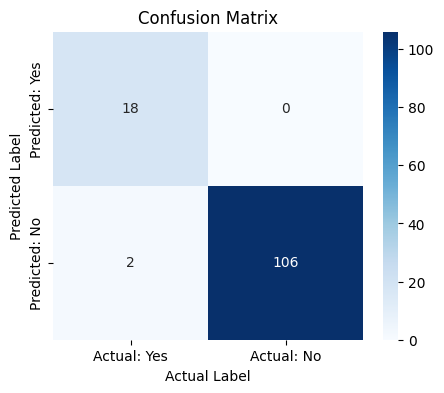

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
plt.show()

**Out-of-Time (OOT) Testing**

In [ ]:
prefix_name="aggregated_3_months"

model_name = f"6850_prediction_{get_datetime()}_{prefix_name}"
print(f"{model_name}")

20250329_0336
6850_prediction_20250329_0336_aggregated_3_months


In [ ]:
# Define model save path
model_path = f"{home_dir}/models/{model_name}"

# Save the trained pipeline model using Spark's built-in method
model.write().overwrite().save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: /content/drive/MyDrive/ TERM 7/MACHINE/churn_prediction/models/6850_prediction_20250329_0336_aggregated_3_months


In [ ]:
from pyspark.ml import PipelineModel

# Load the model
loaded_model = PipelineModel.load(model_path)

print("Model successfully loaded!")

Model successfully loaded!


In [ ]:
import pandas as pd
import numpy as np

# Define the number of synthetic transactions
num_samples = 500

# Generate synthetic transaction dates in 2020
transaction_dates = pd.date_range(start="2020-01-01", end="2020-12-31", periods=num_samples).strftime('%Y-%m-%d')

# Member type distribution (similar to past data)
member_types = np.random.choice(["member", "non-member"], size=num_samples, p=[0.8, 0.2])

# Branches (randomly selecting from A to J)
branches = np.random.choice(list("ABCDEFGHIJ"), size=num_samples)

# Age groups distribution
age_groups = np.random.choice(["18-25", "25-30", "30-35", "35-40", "40-45", "45-50", "50-55", "55-60", "60 Above"],
                              size=num_samples, p=[0.1, 0.1, 0.1, 0.1, 0.1, 0.15, 0.15, 0.1, 0.1])

# Gender distribution
genders = np.random.choice(["MALE", "FEMALE"], size=num_samples, p=[0.45, 0.55])

# Product quantity and amount (similar to previous statistics)
quantities = np.random.randint(1, 20, size=num_samples)
amounts = np.random.choice([100, 2800, 3700, 4600, 6800, 7500, 9900], size=num_samples)

# Card type distribution
card_types = np.random.choice(["REGULAR", "PREMIUM"], size=num_samples, p=[0.75, 0.25])

# Weather conditions
weather_conditions = np.random.choice(["Sunny", "Cloudy", "Rain", "Thunderstorms", "Partly cloudy", "Mostly clear"],
                                      size=num_samples)

# Temperature and real-feel temperatures (normal distribution based on past stats)
temperature_list = np.random.normal(loc=26, scale=5, size=num_samples).astype(int)
realfeel_list = temperature_list + np.random.randint(-3, 3, size=num_samples)

# Create DataFrame
oot_data = pd.DataFrame({
    "transaction_date": transaction_dates,
    "member_type": member_types,
    "branch": branches,
    "age": age_groups,
    "gender": genders,
    "quantity": quantities,
    "amount": amounts,
    "card_type": card_types,
    "weather_list": weather_conditions,
    "temperature_list": temperature_list,
    "realfell_list": realfeel_list
})

# Display first few rows
oot_data.head()

,transaction_date,member_type,branch,age,gender,quantity,amount,card_type,weather_list,temperature_list,realfell_list
0,2020-01-01,member,I,35-40,MALE,18,4600,REGULAR,Cloudy,25,27
1,2020-01-01,member,B,55-60,FEMALE,13,100,PREMIUM,Sunny,32,30
2,2020-01-02,member,J,60 Above,MALE,14,100,REGULAR,Rain,22,22
3,2020-01-03,member,G,45-50,FEMALE,6,2800,PREMIUM,Thunderstorms,30,27
4,2020-01-03,member,I,18-25,FEMALE,8,3700,REGULAR,Partly cloudy,27,24


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Initialize Spark session
spark = SparkSession.builder.master("local[*]").appName("OOT_Predictions").getOrCreate()

# Convert Pandas DataFrame to Spark DataFrame
oot_spark_df = spark.createDataFrame(oot_data)

# Convert Age Group to Numeric Categories
oot_spark_df = oot_spark_df.withColumn(
    "age",
    when(oot_spark_df["age"] == "18-25", 1)
    .when(oot_spark_df["age"] == "25-30", 2)
    .when(oot_spark_df["age"] == "30-35", 3)
    .when(oot_spark_df["age"] == "35-40", 4)
    .when(oot_spark_df["age"] == "40-45", 5)
    .when(oot_spark_df["age"] == "45-50", 6)
    .when(oot_spark_df["age"] == "50-55", 7)
    .when(oot_spark_df["age"] == "55-60", 8)
    .otherwise(9)  # "60 Above"
)

# Define indexers for categorical features
indexers = [
    StringIndexer(inputCol="member_type", outputCol="member_type_idx"),
    StringIndexer(inputCol="branch", outputCol="branch_idx"),
    StringIndexer(inputCol="gender", outputCol="gender_idx"),
    StringIndexer(inputCol="card_type", outputCol="card_type_idx"),
    StringIndexer(inputCol="weather_list", outputCol="weather_idx")
]

# Apply indexers
for indexer in indexers:
    oot_spark_df = indexer.fit(oot_spark_df).transform(oot_spark_df)

# Assemble features into a single vector
feature_cols = ["member_type_idx", "branch_idx", "age", "gender_idx", "quantity", "amount",
                "card_type_idx", "weather_idx", "temperature_list", "realfell_list"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

oot_spark_df = assembler.transform(oot_spark_df)

# Select relevant columns for predictions
oot_spark_df = oot_spark_df.select("features")

# Show the transformed dataset
oot_spark_df.show(5, truncate=False)

+-----------------------------------------------+
|features                                       |
+-----------------------------------------------+
|[0.0,1.0,4.0,1.0,18.0,4600.0,0.0,5.0,25.0,27.0]|
|[0.0,0.0,8.0,0.0,13.0,100.0,1.0,0.0,32.0,30.0] |
|[0.0,7.0,9.0,1.0,14.0,100.0,0.0,1.0,22.0,22.0] |
|[0.0,9.0,6.0,0.0,6.0,2800.0,1.0,3.0,30.0,27.0] |
|[0.0,1.0,1.0,0.0,8.0,3700.0,0.0,2.0,27.0,24.0] |
+-----------------------------------------------+
only showing top 5 rows



In [ ]:
# Install PySpark
!pip install pyspark

# Retry the preprocessing step after installation
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Initialize Spark session
spark = SparkSession.builder.master("local[*]").appName("OOT_Predictions").getOrCreate()

# Convert Pandas DataFrame to Spark DataFrame
oot_spark_df = spark.createDataFrame(oot_data)

# Convert Age Group to Numeric Categories
oot_spark_df = oot_spark_df.withColumn(
    "age",
    when(oot_spark_df["age"] == "18-25", 1)
    .when(oot_spark_df["age"] == "25-30", 2)
    .when(oot_spark_df["age"] == "30-35", 3)
    .when(oot_spark_df["age"] == "35-40", 4)
    .when(oot_spark_df["age"] == "40-45", 5)
    .when(oot_spark_df["age"] == "45-50", 6)
    .when(oot_spark_df["age"] == "50-55", 7)
    .when(oot_spark_df["age"] == "55-60", 8)
    .otherwise(9)  # "60 Above"
)

# Define indexers for categorical features
indexers = [
    StringIndexer(inputCol="member_type", outputCol="member_type_idx"),
    StringIndexer(inputCol="branch", outputCol="branch_idx"),
    StringIndexer(inputCol="gender", outputCol="gender_idx"),
    StringIndexer(inputCol="card_type", outputCol="card_type_idx"),
    StringIndexer(inputCol="weather_list", outputCol="weather_idx")
]

# Apply indexers
for indexer in indexers:
    oot_spark_df = indexer.fit(oot_spark_df).transform(oot_spark_df)

# Assemble features into a single vector
feature_cols = ["member_type_idx", "branch_idx", "age", "gender_idx", "quantity", "amount",
                "card_type_idx", "weather_idx", "temperature_list", "realfell_list"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

oot_spark_df = assembler.transform(oot_spark_df)

# Select relevant columns for predictions
oot_spark_df = oot_spark_df.select("features")

# Show the transformed dataset
oot_spark_df.show(5, truncate=False)

+-----------------------------------------------+
|features                                       |
+-----------------------------------------------+
|[0.0,1.0,4.0,1.0,18.0,4600.0,0.0,5.0,25.0,27.0]|
|[0.0,0.0,8.0,0.0,13.0,100.0,1.0,0.0,32.0,30.0] |
|[0.0,7.0,9.0,1.0,14.0,100.0,0.0,1.0,22.0,22.0] |
|[0.0,9.0,6.0,0.0,6.0,2800.0,1.0,3.0,30.0,27.0] |
|[0.0,1.0,1.0,0.0,8.0,3700.0,0.0,2.0,27.0,24.0] |
+-----------------------------------------------+
only showing top 5 rows

